# 🎓 Retrieval-Augmented Generation (RAG) – Eigenes Frage-Antwort-System auf Studieninhalte

## 🧠 Was ist RAG?

Retrieval-Augmented Generation (RAG) ist ein moderner Ansatz im Bereich Large Language Models (LLMs), bei dem ein Sprachmodell (z. B. GPT) **nicht nur auf seinem Training basiert**, sondern bei Bedarf **externe Informationen** aus einer Wissensquelle abruft – z. B. aus Textdokumenten, Datenbanken oder Webseiten.

👉 Der Vorteil: Das Modell kann auf **aktuelle und individuelle Informationen zugreifen**, ohne dass es komplett neu trainiert werden muss.

---

## 📂 Ziel dieses Projekts

In diesem Projekt habe ich ein RAG-System gebaut, das auf **meine eigenen hochgeladenen PDF-Dokumente** zugreift – konkret:

- Studien- und Prüfungsordnungen
- Modulhandbücher
- Weitere akademische Unterlagen aus meinem Studium

Mithilfe dieses Systems kann ich anschließend **Fragen zu meinen eigenen Studieninhalten stellen**, z. B.:

- *„Wie viele ECTS hat das Praxissemester?“*
- *„Welche Inhalte umfasst das Modul Software Engineering“*
- *„Welche Bedingungen gelten für das Kolloquium?“*

---

## 🔧 Wie funktioniert mein System?

1. **PDF-Dokumente aus Google Drive** werden automatisch geladen
2. Die Texte werden in kleine **Chunks** zerlegt
3. Mit **OpenAI-Embeddings** werden diese Chunks in Vektoren umgewandelt
4. Diese werden in einer **FAISS-Vektor-Datenbank** gespeichert
5. Wenn ich eine Frage stelle:
   - Sucht ein **Retriever** nach passenden Chunks
   - GPT erzeugt auf Basis dieser Textstellen eine **Antwort**

---

## 🎯 Warum ist das hilfreich?

Dieses System simuliert eine **intelligente Studienberatung**, die mir hilft, schnell und präzise Informationen aus offiziellen Unterlagen zu bekommen –  
ohne langes Scrollen und Suchen in PDF-Dateien.

---

## 🛠️ Technologien im Einsatz:

- **LangChain** – Framework für LLM-gestützte Anwendungen
- **OpenAI GPT-3.5 Turbo** – Sprachmodell zur Textgenerierung
- **OpenAI Embeddings (text-embedding-3-large)** – für semantische Suche
- **FAISS** – Vektor-Datenbank für schnelle Ähnlichkeitssuche
- **Google Drive + Colab** – zur Dateiablage und Ausführung

In [1]:
# Installation der erforderlichen Pakete und Komponenten
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph
!pip install faiss-cpu
!pip install -qU "langchain[openai]"
!pip install pypdf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.

In [2]:
# Import notwendiger Bibliotheken
import os, datetime
from getpass import getpass
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from langchain.prompts import PromptTemplate
from typing_extensions import TypedDict, List, Annotated
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph, MessagesState, END
from google.colab import drive
from typing import Literal, List
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, AIMessage, ToolCall
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# OpenAI API Key
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("🔑 OpenAI API Key eingeben: ")

#LangSmith API Key um spätere analyse zu ermöglichen
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass("🔑 LangSmith API Key eingeben: ")

# Wrapper funktion für den Start des GPT modells
llm = init_chat_model("gpt-3.5-turbo", model_provider="openai")


🔑 OpenAI API Key eingeben: ··········
🔑 LangSmith API Key eingeben: ··········


In [4]:
# Vektorrechner: wandelt Text in Vektoren um
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")


In [5]:
# Nötige Pfade
folder_path = "/content/drive/MyDrive/Praxisphase_BIS"
path = "/content/drive/MyDrive/faiss_rag"


In [6]:
# Lade Vektordatenbank aus dem lokalen Speicher, falls vorhanden – andernfalls lade PDF-Dateien, teile sie in Textabschnitte auf, erstelle eine neue FAISS-Vektordatenbank und speichere sie lokal.
force_rebuild = False # → damit neue PDFs eingelesen & neu gechunked werden auf True sonst False

if os.path.exists(path) and not force_rebuild:
    vector_store = FAISS.load_local(path, embeddings, allow_dangerous_deserialization=True)

else:
    loaders = [PyPDFLoader(os.path.join(folder_path, f)) for f in os.listdir(folder_path) if f.endswith(".pdf")]
    docs = sum([loader.load() for loader in loaders], [])
    print(f" {len(docs)} Seiten insgesamt geladen.")
    print(f" Vorschau (erste Seite):\n{docs[0].page_content[:500]}")

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=200)
    all_splits = text_splitter.split_documents(docs)

    # Neue Metadaten setzen (für die Query Analysis)
    total_chunks = len(all_splits)
    third = total_chunks // 3

    for i, doc in enumerate(all_splits):
        if i < third:
            doc.metadata["section"] = "beginning"
        elif i < 2 * third:
            doc.metadata["section"] = "middle"
        else:
            doc.metadata["section"] = "end"

    vector_store = FAISS.from_documents(all_splits, embeddings)
    vector_store.save_local(path)


In [7]:
# Retriever
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    print(f"🔍 RETRIEVAL WIRD AUSGEFÜHRT: {query}")
    retrieved_docs = vector_store.similarity_search(query, k=20)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [8]:
from uuid import uuid4
from langchain_core.messages import AIMessage, ToolCall

def query_or_respond(state: MessagesState):
    query = state["messages"][-1].content
    tool_call = ToolCall(
        id=str(uuid4()),
        name="retrieve",
        args={"query": query}
    )
    ai_msg = AIMessage(content="", tool_calls=[tool_call])
    return {"messages": [ai_msg]}

tools = ToolNode([retrieve])

def generate(state: MessagesState):
    """Final GPT-Antwort basierend auf Tool-Ergebnis."""
    # Tool-Nachrichten extrahieren
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
    "Du bist ein akademischer Studienberater für den Studiengang Wirtschaftsinformatik. "
    "Beantworte die folgende Nutzerfrage sachlich und auf Basis der bereitgestellten Kontextinformationen. "
    "Nutze wirklich nur ausschließlich den Kontext – wenn keine passenden Informationen vorhanden sind, sage ehrlich, dass du es nicht beantworten kannst. "
    "Fasse deine Antwort in maximal drei Sätzen präzise zusammen."
    "Gib keine allgemeine oder erfundene Antwort. \n\n"
        f"{docs_content}"
    )

    conversation_messages = [
        message for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]

    prompt = [SystemMessage(system_message_content)] + conversation_messages
    response = llm.invoke(prompt)
    return {"messages": [response]}


In [9]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("query_or_respond", query_or_respond)
graph_builder.add_node("tools", tools)
graph_builder.add_node("generate", generate)

graph_builder.set_entry_point("query_or_respond")

graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {
        END: END,
        "tools": "tools"
    }
)

graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)



In [10]:
# Memory initialisieren
memory = MemorySaver()

In [11]:
# Kompiliert den Zustandsgraphen zu einem ausführbaren Workflow.
graph = graph_builder.compile(checkpointer=memory)

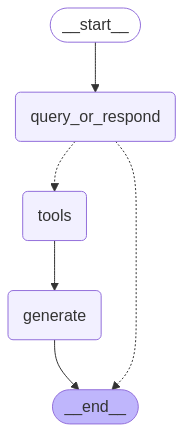

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
input_message = "Wer ist der Professor für das Modul Software Engineering?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config={"configurable": {"thread_id": "default-session"}}
):
    step["messages"][-1].pretty_print()


================================ Human Message =================================

Wer ist der Professor für das Modul Software Engineering?
================================== Ai Message ==================================
Tool Calls:
  retrieve (b73236c0-a631-4f7c-828f-1795fb1cb97e)
 Call ID: b73236c0-a631-4f7c-828f-1795fb1cb97e
  Args:
    query: Wer ist der Professor für das Modul Software Engineering?
🔍 RETRIEVAL WIRD AUSGEFÜHRT: Wer ist der Professor für das Modul Software Engineering?
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'Adobe PDF Library 24.2.229', 'creator': 'Acrobat PDFMaker 24 für Word', 'creationdate': '2024-09-03T11:23:01+02:00', 'author': 'achilles', 'company': 'Fakultät IV, Abt. Wirtschaft', 'keywords': '', 'moddate': '2024-09-03T11:33:33+02:00', 'sourcemodified': 'D:20240903091206', 'subject': '', 'title': 'I', 'source': '/content/drive/MyDrive/Praxisphase_BIS/05-BIS-Studien-Modulhandbuch-PO2

================================== Ai Message ==================================

Der Professor für das Modul Software Engineering ist Dennis Chong.


In [15]:
%pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.1 MB/s eta 0:00:00


In [16]:
import gradio as gr

THREAD_ID = "ubejde-kaso-session"

chat_history = []

def chat_rag(user_message, history):
    response = graph.invoke(
        {"messages": [{"role": "user", "content": user_message}]},
        config={"configurable": {"thread_id": THREAD_ID}}
    )
    assistant_reply = response["messages"][-1].content
    return assistant_reply

gr.ChatInterface(
    fn=chat_rag,
    title="📚 Persönlicher Studienberater RAG für UBEJDE KASO",
    description="Stelle Fragen zu deinem Studium – mit vollständigem Gesprächsverlauf.",
).launch(share=True)


/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:338: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4150709b62665be874.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
